In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Дополнительная лабораторная работа

## Решение одномерной задачи о распаде разрыва в идеальном газе

### Нестационарные уравнения газодинамики

$$ \frac{\partial U}{\partial t} + A \frac{\partial U}{\partial x} = 0 $$

$$ U = \{ \rho, u, \varepsilon\}^T, \space A =
    \begin{Bmatrix}
        u & \rho & 0 \\
        \frac{1}{\rho} \frac{\partial p}{\partial \rho} & u & \frac{1}{\rho} \frac{\partial p}{\partial \varepsilon} \\
        0 & p/\rho  & u
    \end{Bmatrix}.$$

Здесь $\rho$ - плотность, $u$ - скорость газа, $\varepsilon$ - удельная внутренняя энергия газа, $\{t, x\}$ - независимые координаты; $\rho (0, x) = \rho_0$, $u(0, x) = 0$, $\varepsilon (x, 0) = \varepsilon_0$; уравнение состояния:

$$ p - \rho \varepsilon (\gamma - 1) = 0, \space \gamma = 1.4; $$

$$
\rho (0, x) = \begin{cases}
        \rho_1, & y \leq 0, \\
        \rho_2, & x > 0,
    \end{cases}
$$

$$ t \in [0, T]; \space x \in [-X, X]; N_\tau = T, $$

$$ M h = 2 X, \space M= 20, \space 100, \space 1000; \space h \text{ - шаг по } x, \space \tau \text{ - шаг по } t. $$

Сеточно-характеристический метод $(\sigma = \tau / h)$:

$$ U^{n+1}_m = U^n_m - \sigma [(\Omega^{-1} \Lambda^+ \Omega)^n_m (U^n_{m-1} -U^n_m) - (\Omega^{-1} \Lambda^- \Omega)^n_m (U^n_{m+1} -U^n_m)]. $$

Здесь: $\Lambda^{\pm} = (1/2) (\Lambda + |\Lambda|)$, $\Lambda$ - диагональная матрица: $\Lambda = \text{diag} (\lambda_1, \lambda_2, \lambda_3).$ $\lambda_1 = u + c$, $\lambda_2 = u$, $\lambda_3 = u - c$ являются собственными числами матрицы $A$;

$$ \Omega =\begin{Bmatrix}
    \frac{\partial p}{\partial \rho} & \rho c & \frac{\partial p}{\partial \varepsilon} \\
    p & 0 & -\rho^2 \\
    p & -\rho c  & \frac{\partial p}{\partial \rho}
    \end{Bmatrix} = 
    \begin{Bmatrix}
    \omega_1 \\
    \omega_2 \\
    \omega_3
    \end{Bmatrix} $$

\- матрица, строками которой являются соответствующие собственные векторы $A$ (причём $A = \Omega^{-1} \Lambda \Omega$), получаемые из соотношения $\omega_i A = \lambda_i \omega_i.$

<>:153: SyntaxWarning: invalid escape sequence '\s'
<>:153: SyntaxWarning: invalid escape sequence '\s'
C:\Users\MSI\AppData\Local\Temp\ipykernel_29908\995586866.py:153: SyntaxWarning: invalid escape sequence '\s'
  f'T = {T_FINAL:.2f}, $\sigma = \\tau/h = {SIGMA_SCHEME_COEFF}$')


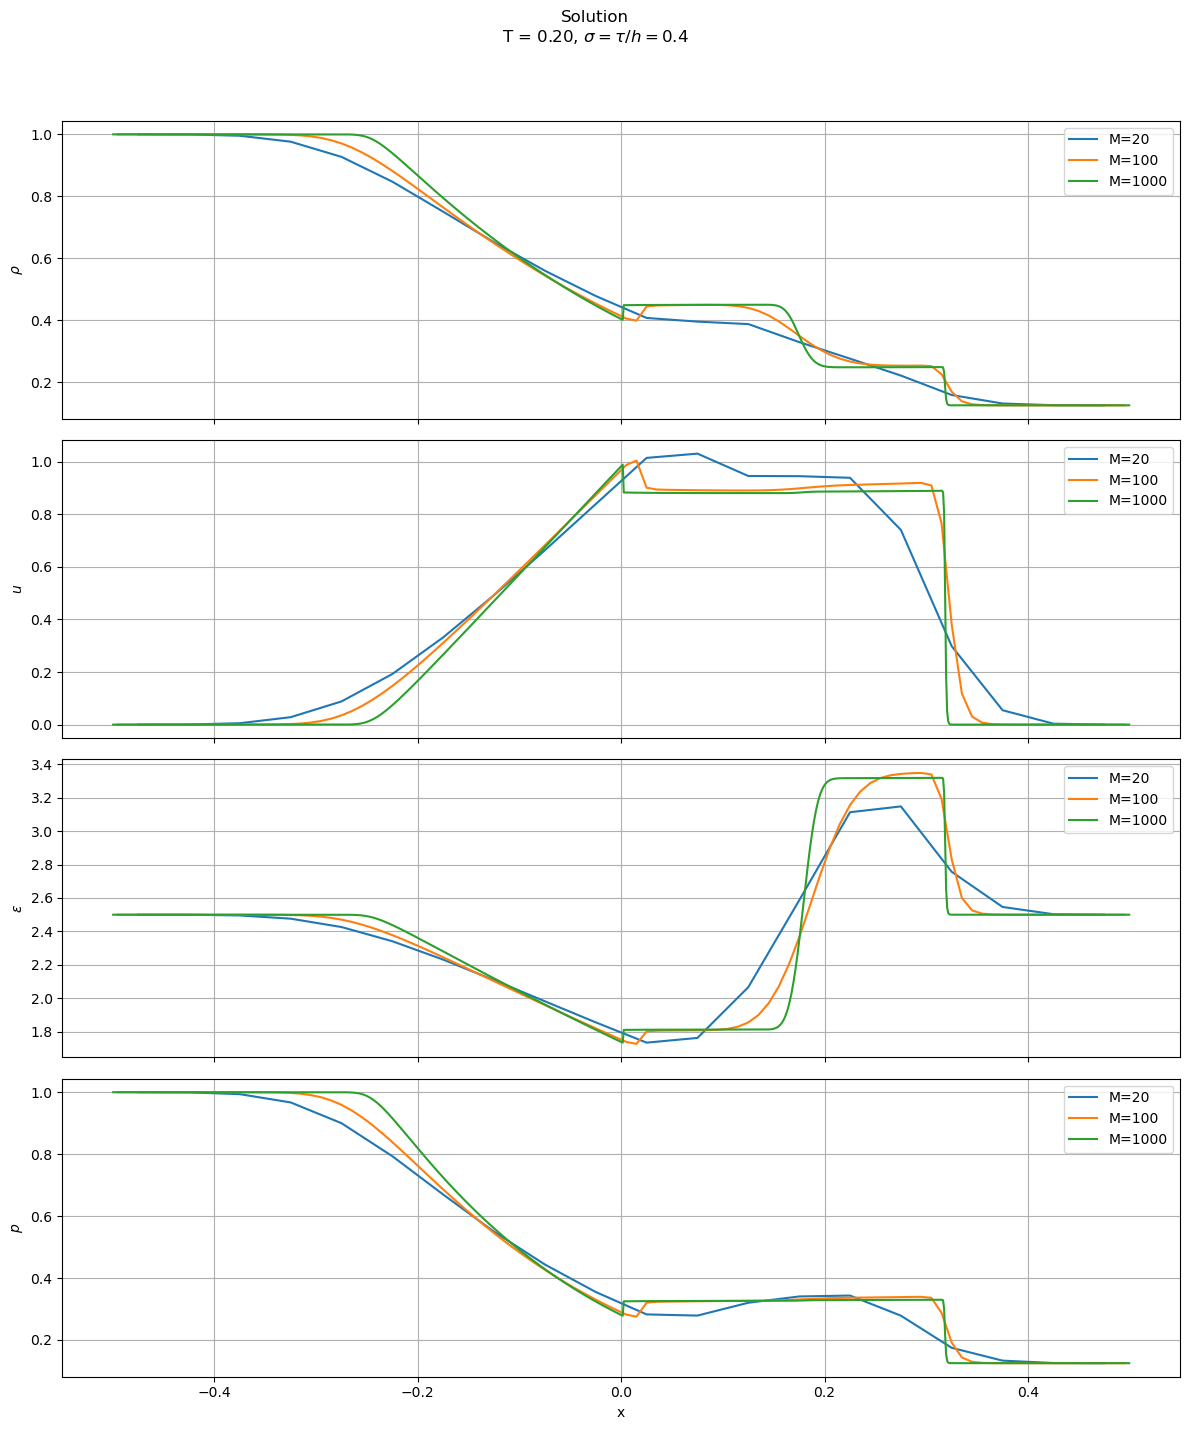

In [7]:
GAMMA = 1.4

X_MIN = -0.5
X_MAX = 0.5
T_FINAL = 0.2 

RHO_L_IC, P_L_IC, U_L_IC = 1.0, 1.0, 0.0
RHO_R_IC = 0.125

EPSILON_0_IC = P_L_IC / (RHO_L_IC * (GAMMA - 1))

P_R_IC = RHO_R_IC * EPSILON_0_IC * (GAMMA - 1)

SIGMA_SCHEME_COEFF = 0.4 

def get_pressure(rho, u_vel, epsilon, gamma_val):
    return rho * epsilon * (gamma_val - 1.0)

def get_sound_speed(rho, pressure, gamma_val):
    return np.sqrt(gamma_val * pressure / rho)

def get_lambda_split_matrices(u_val, c_val):
    lambda_diag = np.array([u_val + c_val, u_val, u_val - c_val])
    
    lambda_plus_diag = np.maximum(0, lambda_diag)
    lambda_minus_diag = np.minimum(0, lambda_diag)
    
    Lambda_plus = np.diag(lambda_plus_diag)
    Lambda_minus = np.diag(lambda_minus_diag)
    return Lambda_plus, Lambda_minus

def get_omega_matrix_from_problem(rho_val, u_val, epsilon_val, c_val, pressure_val, gamma_val):
    dp_drho_const_eps = epsilon_val * (gamma_val - 1.0)
    dp_deps_const_rho = rho_val * (gamma_val - 1.0)
    
    Omega = np.zeros((3,3))
    
    Omega[0,0] = dp_drho_const_eps
    Omega[0,1] = rho_val * c_val
    Omega[0,2] = dp_deps_const_rho

    Omega[1,0] = pressure_val 
    Omega[1,1] = 0.0
    Omega[1,2] = -rho_val**2
    
    Omega[2,0] = dp_drho_const_eps
    Omega[2,1] = -rho_val * c_val
    Omega[2,2] = dp_deps_const_rho
    
    return Omega

def solve_euler_grid_characteristic_method(
    M_nodes, t_final_sim, sigma_coeff, gamma_val,
    rho_l, u_l, eps_l,
    rho_r, u_r, eps_r
    ):
    
    dx = (X_MAX - X_MIN) / M_nodes
    x_centers = np.linspace(X_MIN + dx/2, X_MAX - dx/2, M_nodes)

    dt = sigma_coeff * dx
    num_t_steps = int(t_final_sim / dt)
    if num_t_steps == 0: num_t_steps = 1

    U_current = np.zeros((M_nodes, 3))
    U_next = np.zeros_like(U_current)

    for i in range(M_nodes):
        if x_centers[i] <= 0:
            U_current[i,0] = rho_l      
            U_current[i,1] = u_l        
            U_current[i,2] = eps_l  
        else:
            U_current[i,0] = rho_r      
            U_current[i,1] = u_r        
            U_current[i,2] = eps_r  
    
    actual_time = 0.0
    for n_step in range(num_t_steps):
        actual_time = (n_step + 1) * dt
        
        max_abs_lambda_overall = 0.0
        for m_idx in range(M_nodes):
            rho, u, eps = U_current[m_idx,:]
            p = get_pressure(rho, u, eps, gamma_val)
            c = get_sound_speed(rho, p, gamma_val)
            max_abs_lambda_overall = max(max_abs_lambda_overall, abs(u) + c)
        
        effective_courant_number = sigma_coeff * max_abs_lambda_overall

        U_padded = np.pad(U_current, ((1,1), (0,0)), mode='edge') 

        for m_idx in range(M_nodes):
            m_padded_idx = m_idx + 1

            rho_m, u_m, eps_m = U_padded[m_padded_idx, :]
            
            p_m = get_pressure(rho_m, u_m, eps_m, gamma_val)
                
            c_m = get_sound_speed(rho_m, p_m, gamma_val)

            Omega_m = get_omega_matrix_from_problem(rho_m, u_m, eps_m, c_m, p_m, gamma_val)
            Omega_inv_m = np.linalg.inv(Omega_m)
                        
            Lambda_plus_m, Lambda_minus_m = get_lambda_split_matrices(u_m, c_m)

            A_plus_m  = Omega_inv_m @ Lambda_plus_m @ Omega_m
            A_minus_m = Omega_inv_m @ Lambda_minus_m @ Omega_m
            
            dU_backward = U_padded[m_padded_idx, :] - U_padded[m_padded_idx-1, :]
            dU_forward  = U_padded[m_padded_idx+1, :] - U_padded[m_padded_idx, :]
            
            U_next[m_idx,:] = U_current[m_idx,:] - sigma_coeff * \
                              ( A_plus_m @ dU_backward + A_minus_m @ dU_forward )
        
        U_current = U_next.copy()

    return x_centers, U_current, actual_time

M_values_problem = [20, 100, 1000]

results_dict = {}
for M in M_values_problem:
    x_coords, U_final_state, time_final_calc = solve_euler_grid_characteristic_method(
        M, T_FINAL, SIGMA_SCHEME_COEFF, GAMMA,
        RHO_L_IC, U_L_IC, EPSILON_0_IC,
        RHO_R_IC, U_L_IC, EPSILON_0_IC
    )
    results_dict[M] = {'x': x_coords, 'U': U_final_state, 't': time_final_calc}

fig, axes = plt.subplots(4, 1, figsize=(12, 15), sharex=True)
plot_vars_labels = [r'$\rho$', '$u$', r'$\varepsilon$', '$p$']

for M_val_plot, data in results_dict.items():
    x_plot = data['x']
    U_plot = data['U']
    
    rho_vals = U_plot[:,0]
    u_vals = U_plot[:,1]
    eps_vals = U_plot[:,2]
    p_vals = get_pressure(rho_vals, u_vals, eps_vals, GAMMA)
    
    data_to_plot = [rho_vals, u_vals, eps_vals, p_vals]
    
    for i in range(4):
        axes[i].plot(x_plot, data_to_plot[i], label=f'M={M_val_plot}')
        axes[i].set_ylabel(plot_vars_labels[i])
        axes[i].grid(True)
        if i == 3: axes[i].set_xlabel('x')
        axes[i].legend()

fig.suptitle(f'Solution\n'
             f'T = {T_FINAL:.2f}, $\sigma = \\tau/h = {SIGMA_SCHEME_COEFF}$')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()